# Module 2. Selection framework

We will use factor investing is our starting point. This notebook will present time series momentum

In [1]:
import sys
sys.path.append('../')

from miquants_demo.data_collection.PriceLoader import load_stock_data,load_index_data
from miquants_demo.selection import TSMOM
from miquants_demo.utils.metrics import calc_performance_metrics_subset,calc_sharpe_by_year


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empyrical import stats
import seaborn as sns

In [2]:
help(TSMOM.trend_estimation)

Help on class trend_estimation in module miquants_demo.selection.TSMOM:

class trend_estimation(builtins.object)
 |  Methods defined here:
 |  
 |  macd_estimate(srs, short_timescale, long_timescale)
 |  
 |  old_school_estimate(srs, TS_LENGTH)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [3]:
help(TSMOM.trading_signal)

Help on class trading_signal in module miquants_demo.selection.TSMOM:

class trading_signal(builtins.object)
 |  Methods defined here:
 |  
 |  phi_func(trend)
 |  
 |  sign_func(trend)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [4]:
help(TSMOM.TSMOM)

Help on class TSMOM in module miquants_demo.selection.TSMOM:

class TSMOM(builtins.object)
 |  TSMOM(srs, signal, VOL_LOOKBACK=60, VOL_TARGET=0.35, long_only=True, volatility_scaling=True, T_3=False, transaction_fee=0.001)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, srs, signal, VOL_LOOKBACK=60, VOL_TARGET=0.35, long_only=True, volatility_scaling=True, T_3=False, transaction_fee=0.001)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  calc_daily_vol(self, daily_returns)
 |      ## for volatility targeting
 |  
 |  calc_vol_scaled_returns(self)
 |  
 |  run(self)
 |      ## strategy run here
 |  
 |  transaction_cost(self)
 |  
 |  volatility_target_map(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Univariate time series momentum

Univariate mean consider only 1 stock trade at a time. We will conduct for VCB in 2018-01-01 to 2023-02-28

In [128]:
symbol='HPG'
stock = load_stock_data(symbol,'2016-01-01','2023-02-28')
stock.index = pd.to_datetime(stock.index)
vnindex = load_index_data('VNINDEX','2016-01-01','2023-02-28')
vnindex.index = pd.to_datetime(vnindex.index)
stock

,open,high,low,close,volume
tradingDate,,,,,
2016-01-04,3829.0,3855.0,3789.0,3789.0,404530
2016-01-05,3776.0,3803.0,3750.0,3750.0,628760
2016-01-06,3750.0,3816.0,3750.0,3816.0,658730
2016-01-07,3763.0,3776.0,3697.0,3711.0,1030130
2016-01-08,3645.0,3697.0,3618.0,3645.0,864290
...,...,...,...,...,...
2023-02-22,21400.0,22100.0,21200.0,21200.0,32644751
2023-02-23,21150.0,21500.0,20400.0,21500.0,33600491
2023-02-24,21500.0,21500.0,20650.0,20800.0,14604476


### Daily trade (dreaming scenario)

In [129]:
vnindex['vnindex'] = vnindex['close']
vnindex=vnindex['vnindex'].pct_change()
vnindex.index = pd.to_datetime(vnindex.index)

long_only = pd.DataFrame(columns=['Long only'])
long_only['Long only'] = stock.close.pct_change()

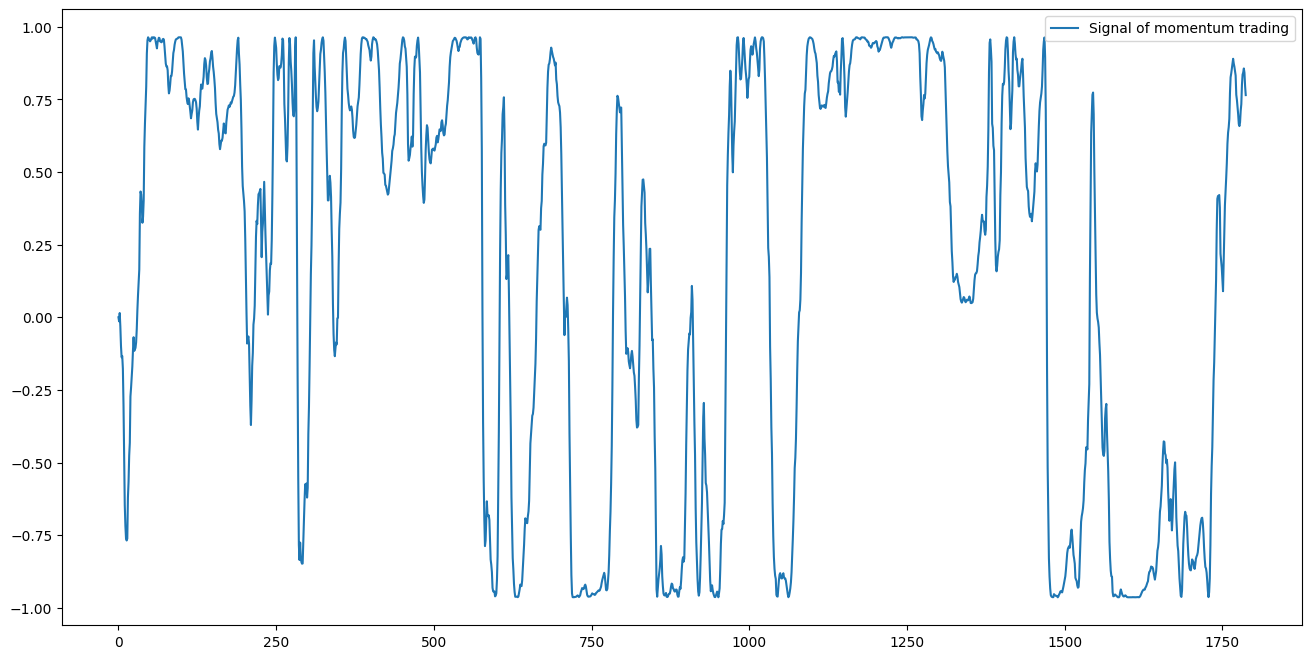

In [130]:
trend_combinations=[(5,20),(8,24),(16,32)]
macd = TSMOM.trend_estimation.macd_estimate
macd = np.sum([TSMOM.trend_estimation.macd_estimate(stock.close, S, L) for S, L in trend_combinations],axis=0)/len(trend_combinations)
signal = TSMOM.trading_signal.phi_func(macd)

fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(signal,label='Signal of momentum trading')
plt.legend()
plt.show()

In [131]:
tsmom = TSMOM.TSMOM(stock.close,signal,long_only=True,VOL_TARGET=0.35,transaction_fee=0.001)
returns = tsmom.run()
returns.index = pd.to_datetime(returns.index)

tsmom1 = TSMOM.TSMOM(stock.close,signal,long_only=True,VOL_TARGET=0.35,transaction_fee=0.0025)
returns1 = tsmom1.run()
returns1.index = pd.to_datetime(returns1.index)
returns1.rename('tsmom higher fee',inplace=True)

tsmom2 = TSMOM.TSMOM(stock.close,signal,long_only=True,volatility_scaling=False,VOL_TARGET=0.35,transaction_fee=0.001)
returns2 = tsmom2.run()
returns2.index = pd.to_datetime(returns2.index)
returns2.rename('tsmom without vol target',inplace=True)

tradingDate
2016-01-04         NaN
2016-01-05         NaN
2016-01-06   -0.000421
2016-01-07   -0.000018
2016-01-08    0.000000
                ...   
2023-02-22    0.011912
2023-02-23   -0.027897
2023-02-24   -0.028318
2023-02-27   -0.003990
2023-02-28         NaN
Name: tsmom without vol target, Length: 1788, dtype: float64

In [132]:
compare = pd.concat([long_only,returns,returns1,returns2,vnindex],axis=1)
compare.fillna(0,inplace=True)
compare

,Long only,tsmom,tsmom higher fee,tsmom without vol target,vnindex
tradingDate,,,,,
2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,-0.010293,0.000000,0.000000,0.000000,-0.007782
2016-01-06,0.017600,-0.000523,-0.000551,-0.000421,0.008124
2016-01-07,-0.027516,-0.000018,-0.000046,-0.000018,-0.016029
2016-01-08,-0.017785,0.000000,0.000000,0.000000,-0.009392
...,...,...,...,...,...
2023-02-22,-0.018519,0.008053,0.008035,0.011912,-0.025826
2023-02-23,0.014151,-0.019151,-0.019173,-0.027897,-0.000588
2023-02-24,-0.032558,-0.019365,-0.019368,-0.028318,-0.013382


In [133]:
stats.cum_returns(compare)

,Long only,tsmom,tsmom higher fee,tsmom without vol target,vnindex
tradingDate,,,,,
2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,-0.010293,0.000000,0.000000,0.000000,-0.007782
2016-01-06,0.007126,-0.000523,-0.000551,-0.000421,0.000279
2016-01-07,-0.020586,-0.000542,-0.000597,-0.000439,-0.015755
2016-01-08,-0.038005,-0.000542,-0.000597,-0.000439,-0.025000
...,...,...,...,...,...
2023-02-22,4.595144,4.176556,3.760147,2.814596,0.835414
2023-02-23,4.674320,4.077418,3.668880,2.708179,0.834334
2023-02-24,4.489575,3.979093,3.578454,2.603172,0.809787


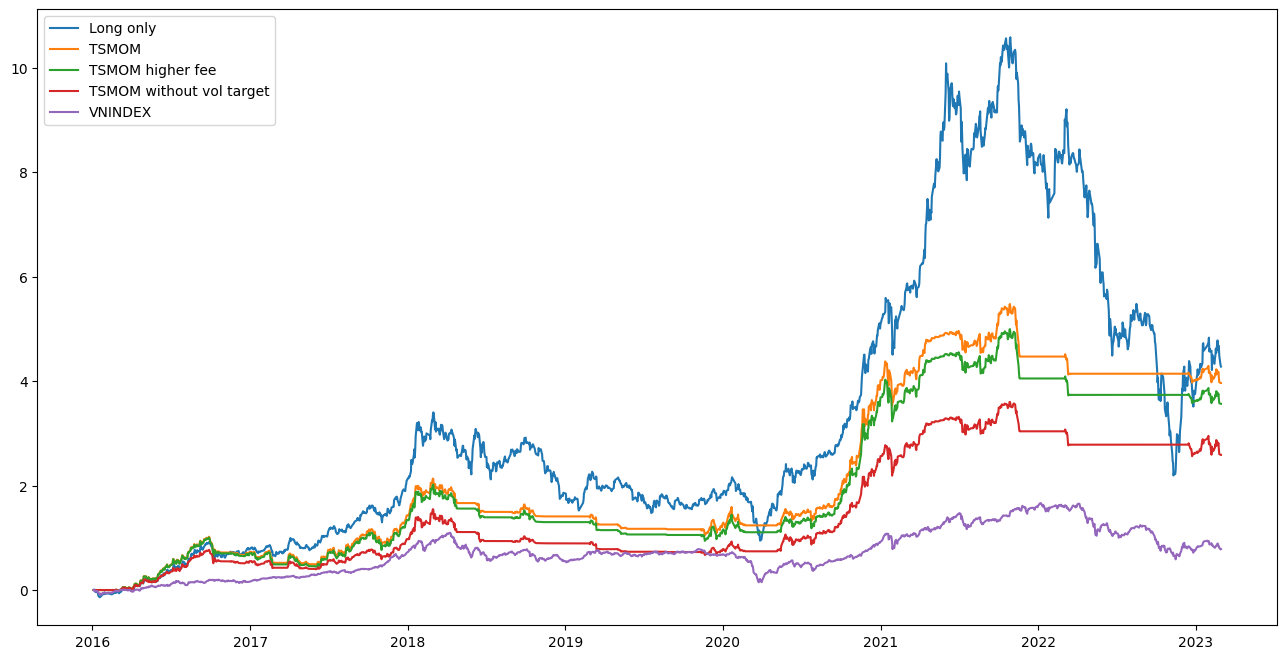

In [134]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.cum_returns(compare['Long only']),label='Long only')
ax.plot(stats.cum_returns(compare.tsmom),label='TSMOM')
ax.plot(stats.cum_returns(compare['tsmom higher fee']),label='TSMOM higher fee')
ax.plot(stats.cum_returns(compare['tsmom without vol target']),label='TSMOM without vol target')
ax.plot(stats.cum_returns(compare.vnindex),label='VNINDEX')
plt.legend()
plt.show()

In [135]:
xxx = calc_performance_metrics_subset(compare)
metrics = pd.DataFrame({'Annual return':xxx['annual_return'],'Annual volatility':xxx['annual_volatility'],'Downside risk':xxx['downside_risk'],'Max drawdown':xxx['max_drawdown'].to_list()})
metrics = metrics.applymap("{0:.2%}".format)
metrics.T

,Long only,tsmom,tsmom higher fee,tsmom without vol target,vnindex
Annual return,26.42%,25.34%,23.87%,19.73%,8.50%
Annual volatility,35.10%,21.48%,21.48%,19.25%,18.90%
Downside risk,23.61%,14.03%,14.07%,12.86%,14.27%
Max drawdown,72.43%,34.63%,35.64%,34.44%,45.26%


In [136]:
x1 = calc_sharpe_by_year(compare[['Long only']].rename(columns={'Long only':'captured_returns'}))
x2 = calc_sharpe_by_year(compare[['tsmom']].rename(columns={'tsmom':'captured_returns'}))
x3 = calc_sharpe_by_year(compare[['tsmom higher fee']].rename(columns={'tsmom higher fee':'captured_returns'}))
x4 = calc_sharpe_by_year(compare[['tsmom without vol target']].rename(columns={'tsmom without vol target':'captured_returns'}))
sharpe_df = pd.DataFrame({'Long only':x1,'tsmom':x2,'tsmom higher fee':x3,'tsmom without vol target':x4})
sharpe_df[:-1]

,Long only,tsmom,tsmom higher fee,tsmom without vol target
sharpe_ratio_2016,2.075317,2.341457,2.284157,2.248659
sharpe_ratio_2017,2.404306,1.435373,1.348339,1.447956
sharpe_ratio_2018,-0.010567,0.065064,0.018406,-0.071245
sharpe_ratio_2019,0.083452,-0.384409,-0.469027,-0.657288
sharpe_ratio_2020,2.301695,2.944322,2.910386,2.895659
sharpe_ratio_2021,1.376776,0.508428,0.449894,0.681736
sharpe_ratio_2022,-1.199910,-1.792253,-1.846703,-1.786011


In [137]:
import scipy
ts = stock.close.pct_change().dropna()

ts1 = compare['tsmom']
## ts2: return of TSMOM with higher fee
ts2 =compare['tsmom higher fee']
## ts3: return of TSMOM without vol target
ts3 =compare['tsmom without vol target']

statistics = scipy.stats.describe(ts)
statistics1 = scipy.stats.describe(ts1)
statistics2 = scipy.stats.describe(ts2)
statistics3 = scipy.stats.describe(ts3)

moment_compare = pd.DataFrame(index=['mean','std','skewness','kurtosis'],columns=['Long only','TSMOM','TSMOM higher fee','TSMOM no vol target'])
moment_compare.loc['mean',:]=round(statistics.mean,4),round(statistics1.mean,4),round(statistics2.mean,4),round(statistics3.mean,4)
moment_compare.loc['std',:]=round(np.sqrt(statistics.variance),4),round(np.sqrt(statistics1.variance),4),round(np.sqrt(statistics2.variance),4),round(np.sqrt(statistics3.variance),4)
moment_compare.loc['skewness',:]=round(statistics.skewness,4),round(statistics1.skewness,4),round(statistics2.skewness,4),round(statistics3.skewness,4)
moment_compare.loc['kurtosis',:]=round(statistics.kurtosis,4),round(statistics1.kurtosis,4),round(statistics2.kurtosis,4),round(statistics3.kurtosis,4)
moment_compare

,Long only,TSMOM,TSMOM higher fee,TSMOM no vol target
mean,0.0012,0.001,0.0009,0.0008
std,0.0221,0.0135,0.0135,0.0121
skewness,0.0308,0.1243,0.1191,-0.0304
kurtosis,1.3647,5.345,5.3461,5.6757


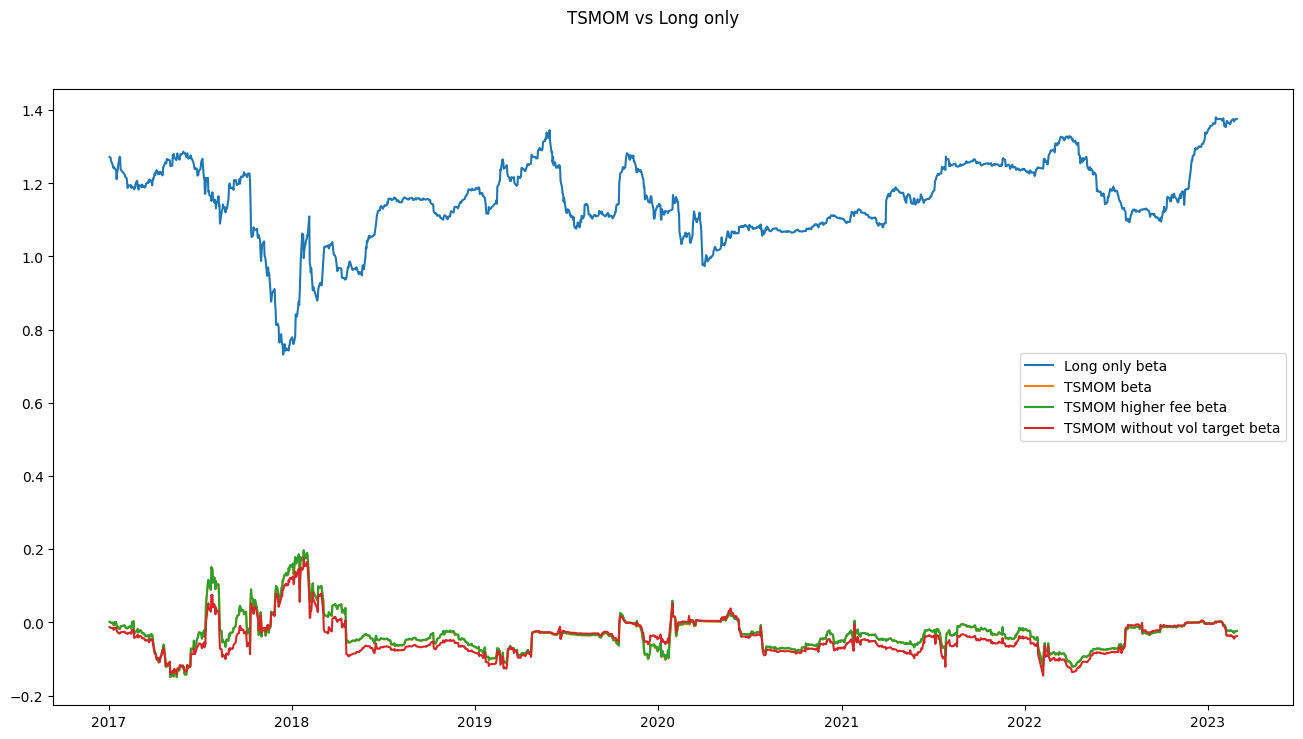

In [138]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.roll_beta(compare['Long only'],compare['vnindex'],window=252),label='Long only beta')
ax.plot(stats.roll_beta(compare['tsmom'],compare['vnindex'],window=252),label='TSMOM beta')
ax.plot(stats.roll_beta(compare['tsmom higher fee'],compare['vnindex'],window=252),label='TSMOM higher fee beta')
ax.plot(stats.roll_beta(compare['tsmom without vol target'],compare['vnindex'],window=252),label='TSMOM without vol target beta')
plt.suptitle('TSMOM vs Long only')
plt.legend()
plt.show()

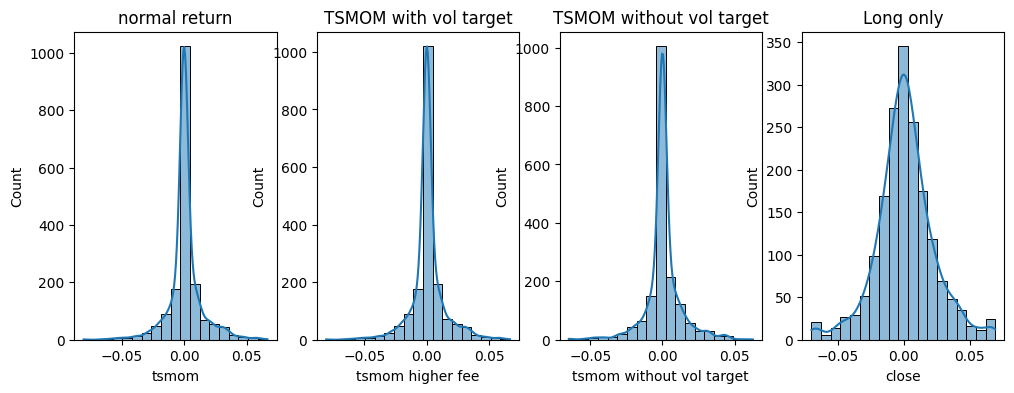

In [139]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(12,4))
bins = 19
sns.histplot(ts1,bins=bins,kde=True,ax=ax1)
ax1.title.set_text('normal return')

sns.histplot(ts2,bins=bins,kde=True,ax=ax2)
ax2.title.set_text('TSMOM with vol target')

sns.histplot(ts3,bins=bins,kde=True,ax=ax3)
ax3.title.set_text('TSMOM without vol target')

sns.histplot(ts,bins=bins,kde=True,ax=ax4)
ax4.title.set_text('Long only')

plt.show()

In [140]:
def winTrade_prob(k3):
    val = 1/2 - (k3/(6*np.sqrt(2*np.pi)))
    return val

print(f'{symbol} || TSMOM win trades probability :',"{:.2%}".format(winTrade_prob(statistics1.skewness)))
print(f'{symbol} || TSMOM win trades probability higher fee:',"{:.2%}".format(winTrade_prob(statistics2.skewness)))
print(f'{symbol} || TSMOM win trades probability without vol target:',"{:.2%}".format(winTrade_prob(statistics3.skewness)))

HPG || TSMOM win trades probability : 49.17%
HPG || TSMOM win trades probability higher fee: 49.21%
HPG || TSMOM win trades probability without vol target: 50.20%


## T+3 scenario

In [18]:
symbol='HPG'
stock = load_stock_data(symbol,'2018-01-01','2023-02-28')
stock.index = pd.to_datetime(stock.index)
vnindex = load_index_data('VNINDEX','2018-01-01','2023-02-28')
vnindex.index = pd.to_datetime(vnindex.index)

stock = stock.resample('3D',origin='end').last()
vnindex = vnindex.resample('3D',origin='end').last()

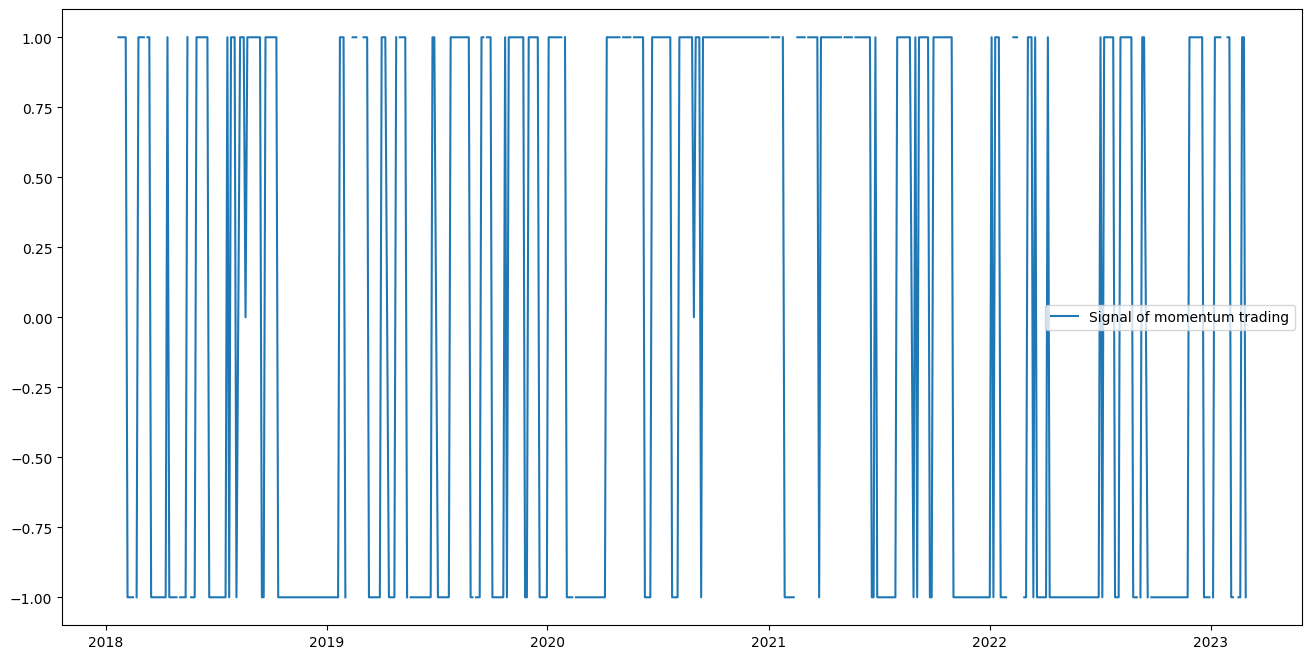

In [19]:
old_school = TSMOM.trend_estimation.old_school_estimate
old_school = old_school(stock.close,TS_LENGTH=6)
signal = TSMOM.trading_signal.sign_func(old_school)

fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(signal,label='Signal of momentum trading')
plt.legend()
plt.show()

In [20]:
tsmom = TSMOM.TSMOM(stock.close,signal,long_only=True,VOL_TARGET=0.35,transaction_fee=0.001,T_3=True)
returns = tsmom.run()
returns.index = pd.to_datetime(returns.index)

tsmom1 = TSMOM.TSMOM(stock.close,signal,long_only=True,VOL_TARGET=0.35,transaction_fee=0.0025,T_3=True)
returns1 = tsmom1.run()
returns1.index = pd.to_datetime(returns1.index)
returns1.rename('tsmom higher fee',inplace=True)

tsmom2 = TSMOM.TSMOM(stock.close,signal,long_only=True,volatility_scaling=False,VOL_TARGET=0.35,transaction_fee=0.001,T_3=True)
returns2 = tsmom2.run()
returns2.index = pd.to_datetime(returns2.index)
returns2.rename('tsmom without vol target',inplace=True)

tradingDate
2018-01-04        NaN
2018-01-07        NaN
2018-01-10        NaN
2018-01-13        NaN
2018-01-16        NaN
               ...   
2023-02-16        NaN
2023-02-19    0.00000
2023-02-22   -0.01967
2023-02-25   -0.03851
2023-02-28        NaN
Freq: 3D, Name: tsmom without vol target, Length: 628, dtype: float64

In [21]:
vnindex['vnindex'] = vnindex['close']
vnindex=vnindex['vnindex'].pct_change()
vnindex.index = pd.to_datetime(vnindex.index)

long_only = pd.DataFrame(columns=['Long only'])
long_only['Long only'] = stock.close.pct_change()

In [22]:
compare = pd.concat([long_only,returns,returns1,returns2,vnindex],axis=1)
compare.fillna(0,inplace=True)
compare

,Long only,tsmom,tsmom higher fee,tsmom without vol target,vnindex
tradingDate,,,,,
2018-01-04,0.000000,0.000000,0.000000,0.00000,0.000000
2018-01-07,-0.004148,0.000000,0.000000,0.00000,-0.006962
2018-01-10,0.077051,0.000000,0.000000,0.00000,0.025142
2018-01-13,0.007734,0.000000,0.000000,0.00000,0.011559
2018-01-16,0.074904,0.000000,0.000000,0.00000,0.012237
...,...,...,...,...,...
2023-02-16,0.054455,0.000000,0.000000,0.00000,0.013979
2023-02-19,-0.014085,0.000000,0.000000,0.00000,0.000964
2023-02-22,0.009524,-0.016865,-0.018068,-0.01967,-0.004748


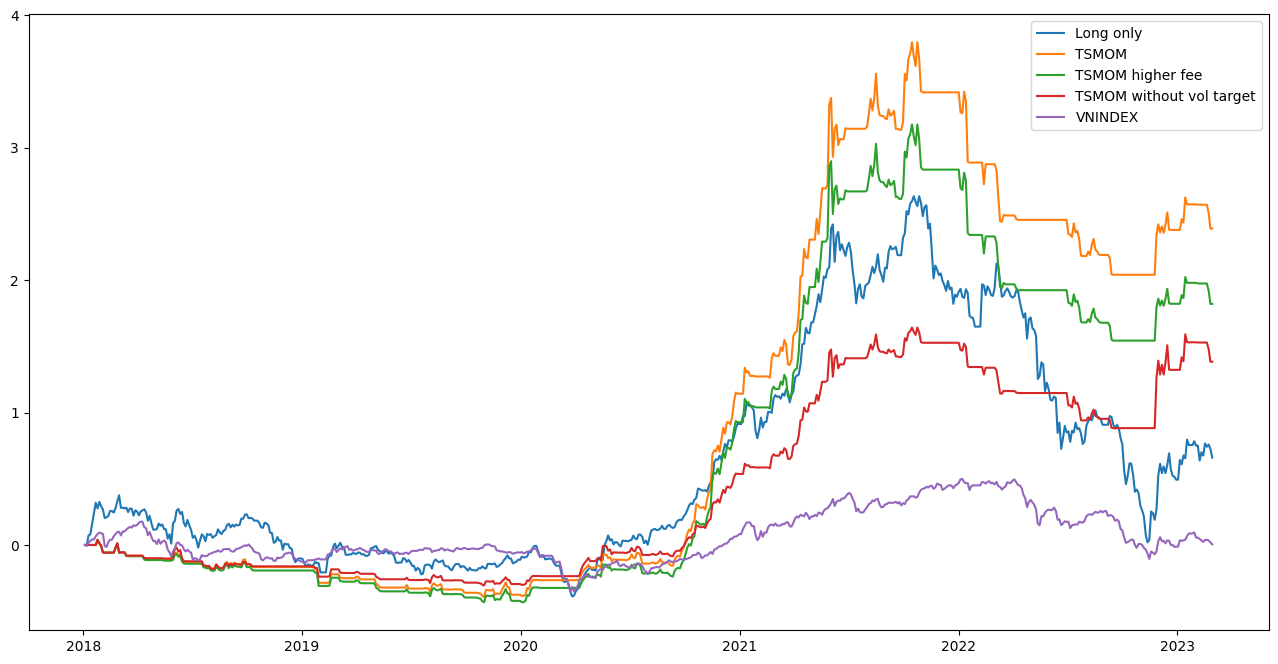

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.cum_returns(compare['Long only']),label='Long only')
ax.plot(stats.cum_returns(compare.tsmom),label='TSMOM')
ax.plot(stats.cum_returns(compare['tsmom higher fee']),label='TSMOM higher fee')
ax.plot(stats.cum_returns(compare['tsmom without vol target']),label='TSMOM without vol target')
ax.plot(stats.cum_returns(compare.vnindex),label='VNINDEX')
plt.legend()
plt.show()

In [24]:
xxx = calc_performance_metrics_subset(compare)
metrics = pd.DataFrame({'Annual return':xxx['annual_return'],'Annual volatility':xxx['annual_volatility'],'Downside risk':xxx['downside_risk'],'Max drawdown':xxx['max_drawdown'].to_list()})
metrics = metrics.applymap("{0:.2%}".format)
metrics.T

,Long only,tsmom,tsmom higher fee,tsmom without vol target,vnindex
Annual return,22.53%,63.21%,51.62%,41.71%,0.19%
Annual volatility,55.84%,39.83%,39.86%,32.44%,29.81%
Downside risk,36.49%,22.62%,22.81%,18.27%,22.48%
Max drawdown,71.93%,41.56%,45.37%,33.11%,45.06%


In [25]:
x1 = calc_sharpe_by_year(compare[['Long only']].rename(columns={'Long only':'captured_returns'}))
x2 = calc_sharpe_by_year(compare[['tsmom']].rename(columns={'tsmom':'captured_returns'}))
x3 = calc_sharpe_by_year(compare[['tsmom higher fee']].rename(columns={'tsmom higher fee':'captured_returns'}))
x4 = calc_sharpe_by_year(compare[['tsmom without vol target']].rename(columns={'tsmom without vol target':'captured_returns'}))
sharpe_df = pd.DataFrame({'Long only':x1,'tsmom':x2,'tsmom higher fee':x3,'tsmom without vol target':x4})
sharpe_df[:-1]

,Long only,tsmom,tsmom higher fee,tsmom without vol target
sharpe_ratio_2018,-0.118900,-1.393614,-1.660109,-1.281177
sharpe_ratio_2019,0.142145,-1.360510,-1.607073,-1.330326
sharpe_ratio_2020,3.501312,5.470300,5.341103,4.950108
sharpe_ratio_2021,2.070161,3.328345,3.170977,3.298774
sharpe_ratio_2022,-1.379613,-1.684018,-1.948185,-0.252615


In [26]:
ts = stock.close.pct_change().dropna()

ts1 = compare['tsmom']
## ts2: return of TSMOM with higher fee
ts2 =compare['tsmom higher fee']
## ts3: return of TSMOM without vol target
ts3 =compare['tsmom without vol target']

statistics = scipy.stats.describe(ts)
statistics1 = scipy.stats.describe(ts1)
statistics2 = scipy.stats.describe(ts2)
statistics3 = scipy.stats.describe(ts3)

moment_compare = pd.DataFrame(index=['mean','std','skewness','kurtosis'],columns=['Long only','TSMOM','TSMOM higher fee','TSMOM no vol target'])
moment_compare.loc['mean',:]=round(statistics.mean,4),round(statistics1.mean,4),round(statistics2.mean,4),round(statistics3.mean,4)
moment_compare.loc['std',:]=round(np.sqrt(statistics.variance),4),round(np.sqrt(statistics1.variance),4),round(np.sqrt(statistics2.variance),4),round(np.sqrt(statistics3.variance),4)
moment_compare.loc['skewness',:]=round(statistics.skewness,4),round(statistics1.skewness,4),round(statistics2.skewness,4),round(statistics3.skewness,4)
moment_compare.loc['kurtosis',:]=round(statistics.kurtosis,4),round(statistics1.kurtosis,4),round(statistics2.kurtosis,4),round(statistics3.kurtosis,4)
moment_compare

,Long only,TSMOM,TSMOM higher fee,TSMOM no vol target
mean,0.0014,0.0023,0.002,0.0016
std,0.0352,0.0251,0.0251,0.0204
skewness,0.6344,1.393,1.4001,2.1571
kurtosis,4.822,11.1804,11.1973,19.7938


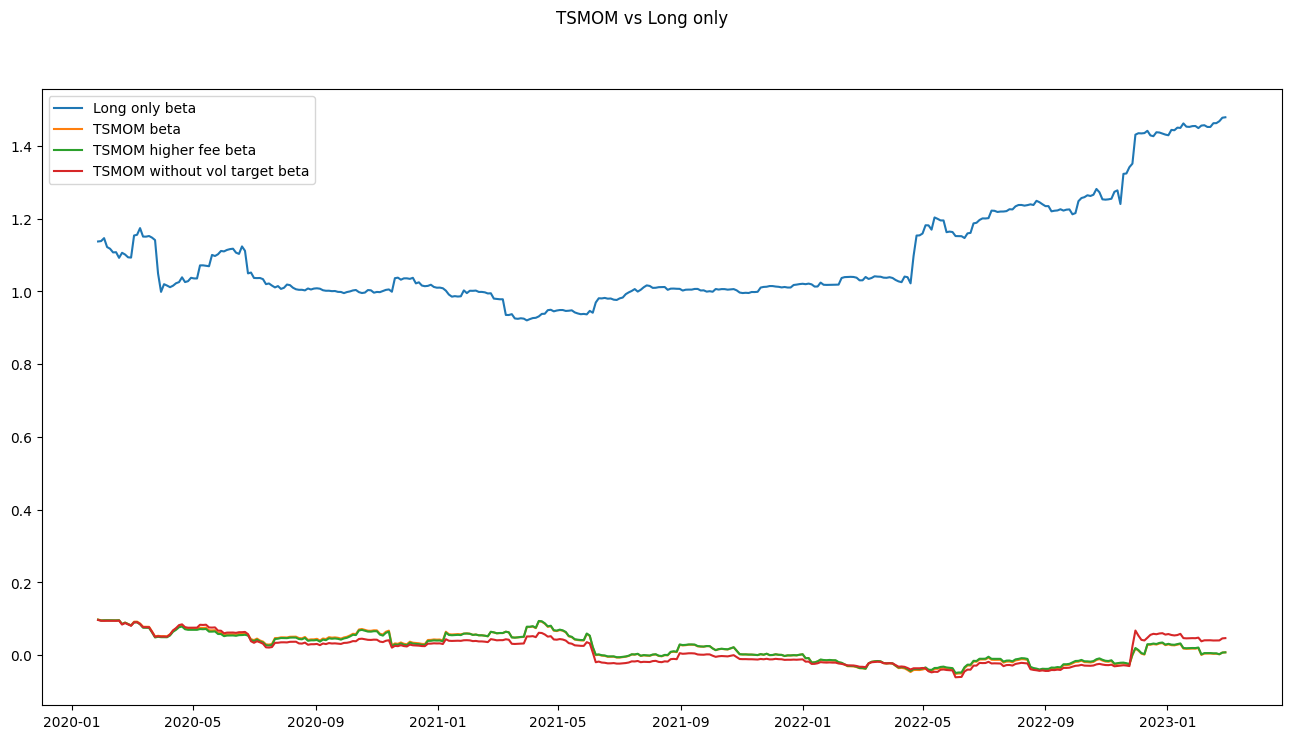

In [27]:
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.plot(stats.roll_beta(compare['Long only'],compare['vnindex'],window=252),label='Long only beta')
ax.plot(stats.roll_beta(compare['tsmom'],compare['vnindex'],window=252),label='TSMOM beta')
ax.plot(stats.roll_beta(compare['tsmom higher fee'],compare['vnindex'],window=252),label='TSMOM higher fee beta')
ax.plot(stats.roll_beta(compare['tsmom without vol target'],compare['vnindex'],window=252),label='TSMOM without vol target beta')
plt.suptitle('TSMOM vs Long only')
plt.legend()
plt.show()

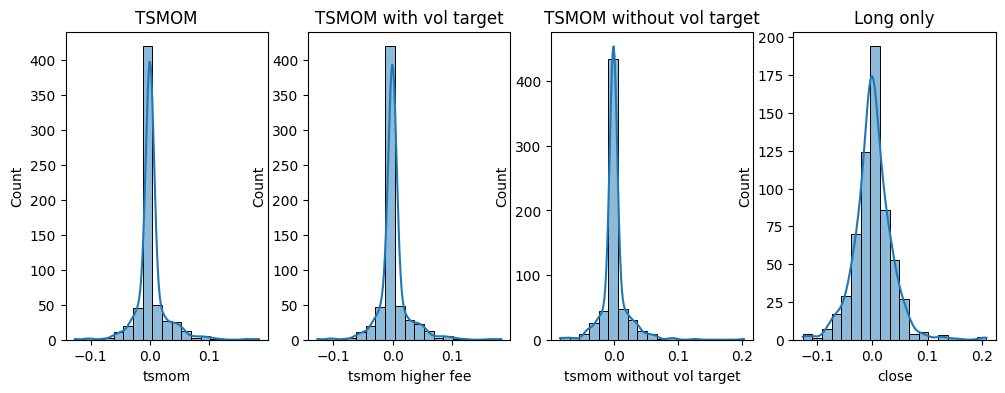

In [30]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(12,4))
bins = 19
sns.histplot(ts1,bins=bins,kde=True,ax=ax1)
ax1.title.set_text('TSMOM')

sns.histplot(ts2,bins=bins,kde=True,ax=ax2)
ax2.title.set_text('TSMOM with vol target')

sns.histplot(ts3,bins=bins,kde=True,ax=ax3)
ax3.title.set_text('TSMOM without vol target')

sns.histplot(ts,bins=bins,kde=True,ax=ax4)
ax4.title.set_text('Long only')

plt.show()

In [29]:
def winTrade_prob(k3):
    val = 1/2 - (k3/(6*np.sqrt(2*np.pi)))
    return val

print(f'{symbol} || TSMOM win trades probability :',"{:.2%}".format(winTrade_prob(statistics1.skewness)))
print(f'{symbol} || TSMOM win trades probability higher fee:',"{:.2%}".format(winTrade_prob(statistics2.skewness)))
print(f'{symbol} || TSMOM win trades probability without vol target:',"{:.2%}".format(winTrade_prob(statistics3.skewness)))

HPG || TSMOM win trades probability : 40.74%
HPG || TSMOM win trades probability higher fee: 40.69%
HPG || TSMOM win trades probability without vol target: 35.66%
